## DASC 550 Project1: Churn Classification Problem
### [[Hamza]] [[Dehidi]]
### 0077989

#### Submission Deadline: August 15, 2022 11:59 PM

In this project, you are going to build an end-to-end machine learning solution using a multilayer preceptron for churn classification problem. You should use `tensorflow` library to build your neural network.

The data set is provided in `Project1.csv` file, which contains 10000 rows and 14 columns. Some of the columns such as RowNumber and CustomerID might be useless for classification. The binary target variable is given in `Exited` column.

While building your classification model, you should use the first 8000 rows as training set and the remaining 2000 rows as test set. You should report the predictive performances on learning, validation and test sets.

You should also decide (i) which features will be included in the classifier, (ii) which features will be preprocessed (e.g., categorical to numeric conversion, scaling, etc.). You should report your decisions and the reasoning behind them.

You should also report the metrics you choose to measure the performance of the solution you developed and the reasoning behind your choices. Please note that the training and test sets have 20.59\% and 19.50\% positive samples, respectively.

In [98]:
import numpy as np
np.random.seed(77989)
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.utils.set_random_seed(77989)

## Importing the data


In [99]:
data = pd.read_csv("Project1.csv")

## Checking null values

In [100]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [101]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**RowNumber, CustomerId & Surname are unnecessary features, so I will drop them**

In [102]:
# Customer ID is unnecessary for our forecast and should therefore be dropped.
data.drop(labels = ['RowNumber','CustomerId','Surname'],axis='columns',inplace=True)

In [103]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Plotting the feature to comprehend its scale and distributions

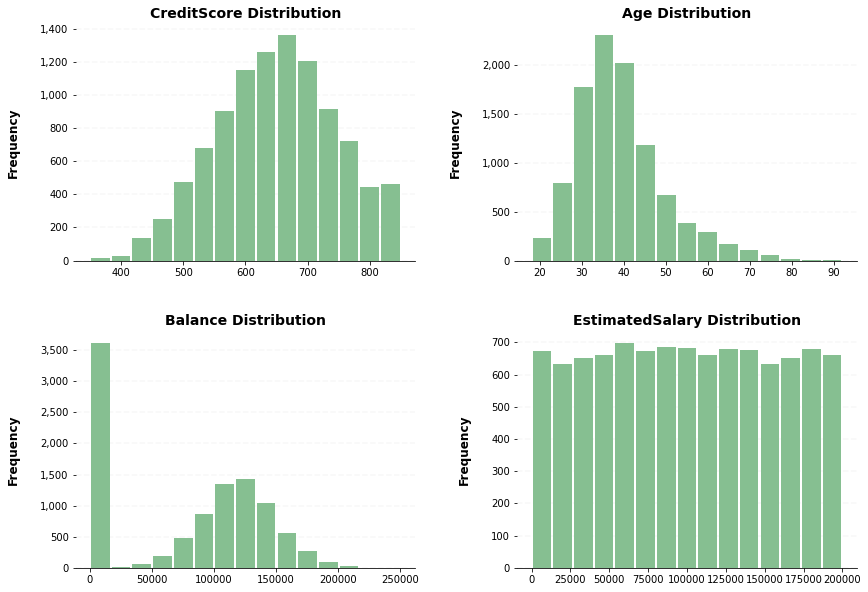

In [104]:
import matplotlib.transforms as mtransforms
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as ticker


ax = data[["CreditScore","Age","Balance", "EstimatedSalary"]].hist(bins=15, grid=False, figsize=(14,10), color='#86bf91', zorder=2, rwidth=0.9)
ax = ax.ravel()

columns = ["CreditScore", "Age", "Balance", "EstimatedSalary"]

for i, x in enumerate (ax):

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)


    # Draw horizontal axis lines
    vals = x.get_yticks()[:-1]
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Set y-axis label
    x.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    
    # Format Title
    x.set_title(f"{columns[i]} Distribution",weight='bold', fontsize=14)
    

**Estimated Salary does not follow a normal distribution.**

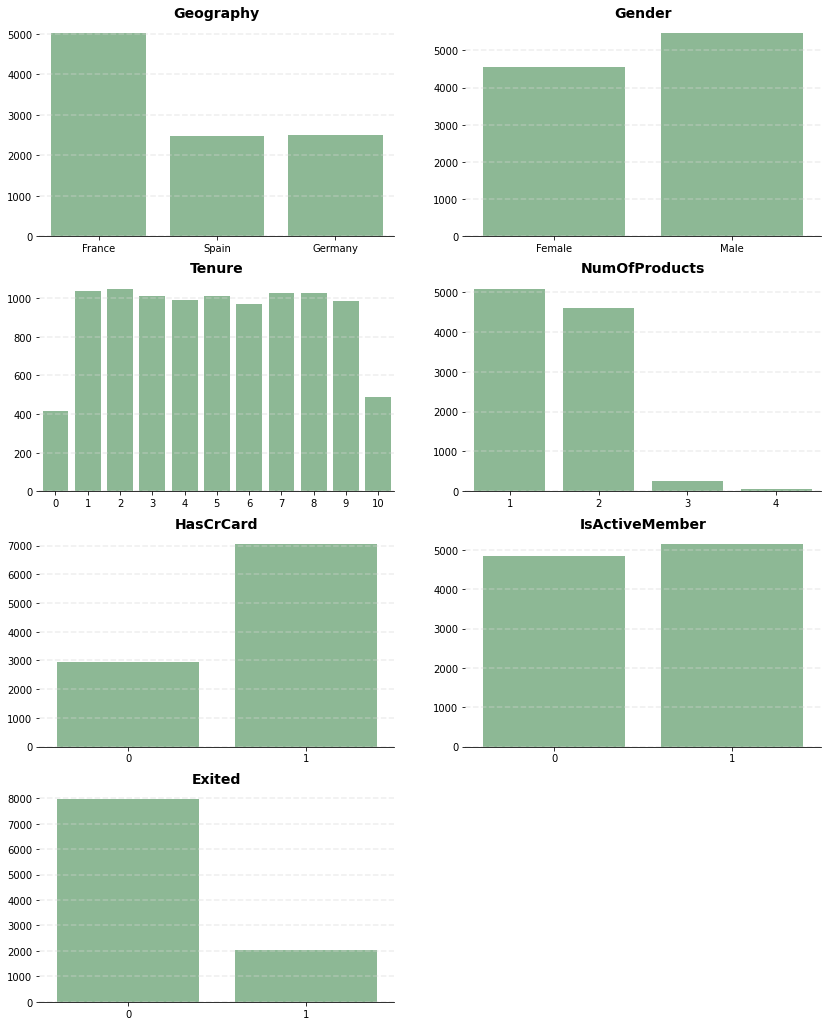

In [105]:
import seaborn as sns
# Lower Green Monochromatic Color Palette
lower_green =['#86bf91']
#lower_green = ["#ddede0","#bcdbc2","#9acaa3","#79b885","#58a666","#468552","#34643d","#234229"]

columns = ["Geography","Gender","Tenure","NumOfProducts","HasCrCard","IsActiveMember","Exited"]

fig, axs = plt.subplots(4, 2, figsize = (14, 18))
fig.delaxes(ax = axs[3,1]) 
ax = axs.ravel()

for i, x in enumerate (ax[:-1]):
  # Despine
  x.spines['right'].set_visible(False)
  x.spines['top'].set_visible(False)
  x.spines['left'].set_visible(False)

  sns.countplot(data=data, x=columns[i], palette=sns.color_palette(lower_green), ax= x)

  # Format Title
  x.set_title(f"{columns[i]}", weight='bold', fontsize=14)
  
  # Remove xlabel
  x.set(ylabel=None)
  x.set(xlabel=None)

  # Draw horizontal axis lines
  vals = x.get_yticks()[:-1]
  for tick in vals:
      x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#d6d6d6', zorder=1)
        

**The Exited are unbalanced; So using AUC is necessary in such case.**

## Splitting the data.

In [106]:
X = data.drop('Exited',axis=1)
y = data['Exited']

In [107]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


## One Hot Encoding the categorical features

In [108]:
X= pd.get_dummies(X)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0


## Dropping correlated dummies

In [109]:
X.drop(labels = ['Geography_Spain','Gender_Male'],axis='columns',inplace=True)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Gender_Female
0,619,42,2,0.00,1,1,1,101348.88,1,0,1
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,1
3,699,39,1,0.00,2,0,0,93826.63,1,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


## Splitting the data to Train and Test

In [110]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                stratify = y,
                                                test_size = 0.20,
                                                random_state = 1234)

print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(8000, 11) (8000,) (2000, 11) (2000,)


## Splitting the Training data to Learn & Validation.

In [111]:
Xlearn, Xval, ylearn, yval = train_test_split(Xtrain, ytrain,
                                              stratify = ytrain,
                                              random_state = 1234,
                                              shuffle = True,
                                              test_size =1/8)
 
print(Xlearn.shape, ylearn.shape)
print(Xval.shape, yval.shape)

(7000, 11) (7000,)
(1000, 11) (1000,)


## Scaling the numerical features.

In [112]:
cols_to_scale = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range=(0.5,0.95))
#scaler = StandardScaler()

Xlearn[cols_to_scale] = scaler.fit_transform(Xlearn[cols_to_scale])
Xval[cols_to_scale] = scaler.transform(Xval[cols_to_scale])
Xtest[cols_to_scale] = scaler.transform(Xtest[cols_to_scale])

In [113]:
Xlearn.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Gender_Female
5835,0.7331,0.615541,0.725,0.731930,0.50,1,1,0.560278,0,0,0
1225,0.8213,0.712838,0.770,0.696688,0.50,1,1,0.617257,0,0,1
5860,0.5927,0.615541,0.680,0.736453,0.65,1,0,0.520116,1,0,1
6397,0.6800,0.591216,0.905,0.630549,0.50,1,1,0.733160,0,0,1
8193,0.7178,0.791892,0.725,0.768944,0.50,1,1,0.671626,1,0,1


## Building NN

In [125]:
n_features = Xlearn.shape[1]

def get_model(L1_output=12,L2_output=6, activation="relu",optimizer="adam"):

  model = keras.Sequential([
  layers.Dense(L1_output, activation=activation,input_shape =(n_features,)),
  layers.Dense(L2_output, activation=activation),
  layers.Dense(1, activation= "sigmoid")
  ])

  model.compile(optimizer= optimizer,
  loss="binary_crossentropy",
  metrics=["accuracy","AUC"])

  return model

### Plotting the training and validation loss, Acc & AUC

In [115]:
def plot_history(history):
  fig, axs = plt.subplots(1, 3, figsize = (14, 5))
  ax = axs.ravel()

  history_ = history.history
  loss = history_["loss"]
  val_loss = history_["val_loss"]

  acc = history_["accuracy"]
  val_acc = history_["val_accuracy"]
  
  auc = history_["auc"]
  val_auc = history_["val_auc"]

  epochs = range(1, len(loss) + 1)

  for i, x in enumerate (ax):
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    if i ==0:    
      sns.lineplot(x=epochs, y= loss, label="Training loss", ax= x)
      sns.lineplot(x=epochs, y= val_loss, label="Validation loss", ax= x)
      # Format Title
      x.set_title("Training and validation loss", weight='bold', fontsize=14)
      # Format ylabel
      x.set(ylabel="Loss")

    elif i==1:
      sns.lineplot(x=epochs, y= acc, label="Training acc", ax= x)
      sns.lineplot(x=epochs, y= val_acc, label="Validation acc", ax= x)
      # Format Title
      x.set_title("Training and validation accuracy", weight='bold', fontsize=14)
      # Format ylabel
      x.set(ylabel="Accuracy")

    else:
      sns.lineplot(x=epochs, y= auc, label="Training AUC", ax= x)
      sns.lineplot(x=epochs, y= val_auc, label="Validation AUC", ax= x)
      # Format Title
      x.set_title("Training and validation AUC", weight='bold', fontsize=14)
      # Format ylabel
      x.set(ylabel="AUC")

    # Format xlabel
    x.set(xlabel="Epochs")
    x.legend()


## Experimenting with various node combinations in the hidden layers.

In [124]:
outputs = [6,8,12,24]
history_dict = {}
models_dict = {}
for i, output in enumerate(outputs):
  models_dict[i] = get_model(L1_output= output,L2_output= output/2) # second hidden layer is half of the previous layer.
  history_dict[i] = models_dict[i].fit(Xlearn,
                    ylearn,
                    epochs=50,
                    batch_size=32,
                    verbose = 0,
                    shuffle = False,
                    validation_data=(Xval, yval))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 6)                 72        
                                                                 
 dense_78 (Dense)            (None, 3)                 21        
                                                                 
 dense_79 (Dense)            (None, 1)                 4         
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


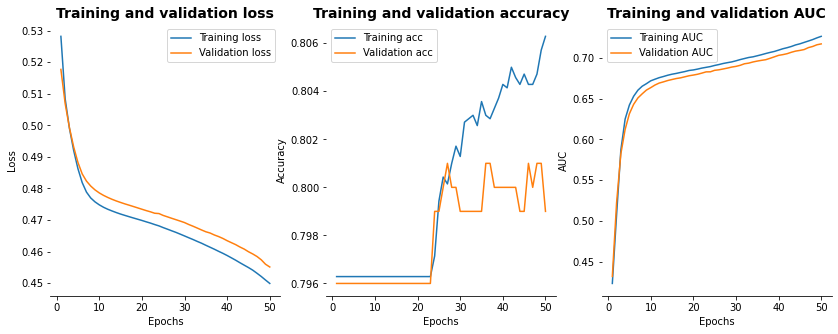

In [117]:
models_dict[0].summary()
plot_history(history_dict[0])

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 8)                 96        
                                                                 
 dense_81 (Dense)            (None, 4)                 36        
                                                                 
 dense_82 (Dense)            (None, 1)                 5         
                                                                 
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________


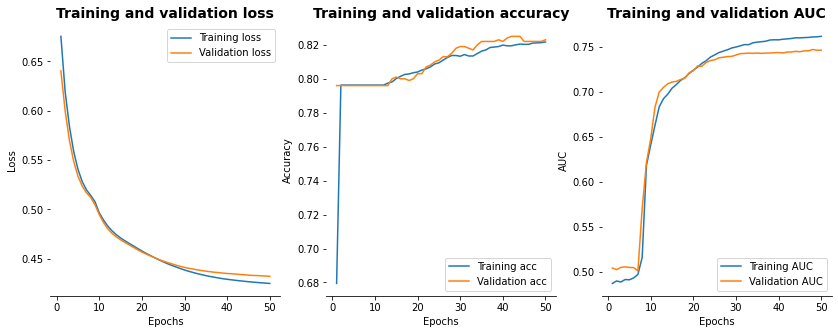

In [118]:
models_dict[1].summary()
plot_history(history_dict[1])

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 12)                144       
                                                                 
 dense_84 (Dense)            (None, 6)                 78        
                                                                 
 dense_85 (Dense)            (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


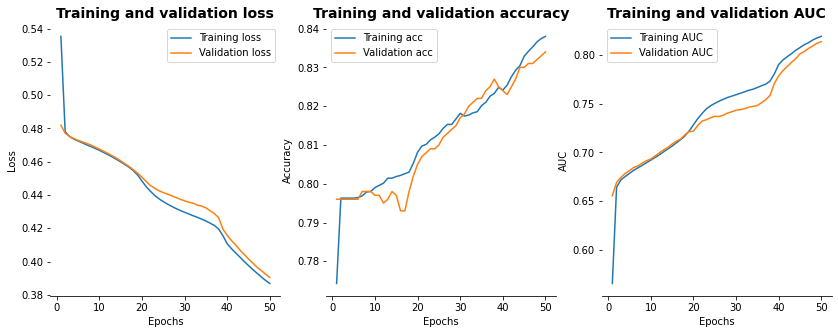

In [119]:
models_dict[2].summary()
plot_history(history_dict[2])

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_86 (Dense)            (None, 24)                288       
                                                                 
 dense_87 (Dense)            (None, 12)                300       
                                                                 
 dense_88 (Dense)            (None, 1)                 13        
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


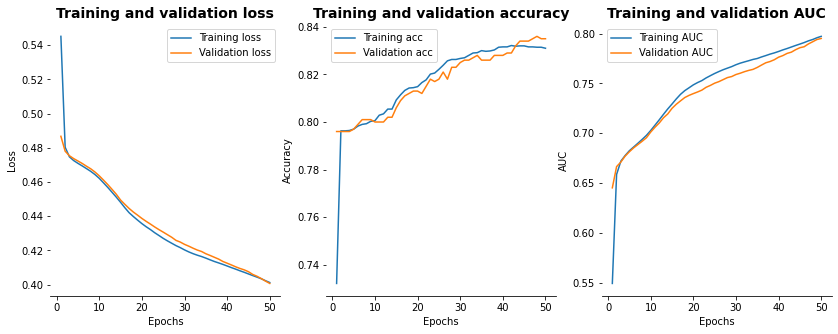

In [120]:
models_dict[3].summary()
plot_history(history_dict[3])

**The results from (12,6) & (24,12) seem to be the best; I'll pick (12,6) because it's simpler and the accuracy is still improving..**

## Let's try to force the model to overfit by incease the epochs and find the optimal point.

In [127]:
model= get_model()
history= model.fit(Xlearn,
                      ylearn,
                      epochs=400,
                      batch_size=32,
                      verbose = 0,
                      shuffle = False,
                      validation_data=(Xval, yval))

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 12)                144       
                                                                 
 dense_129 (Dense)           (None, 6)                 78        
                                                                 
 dense_130 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


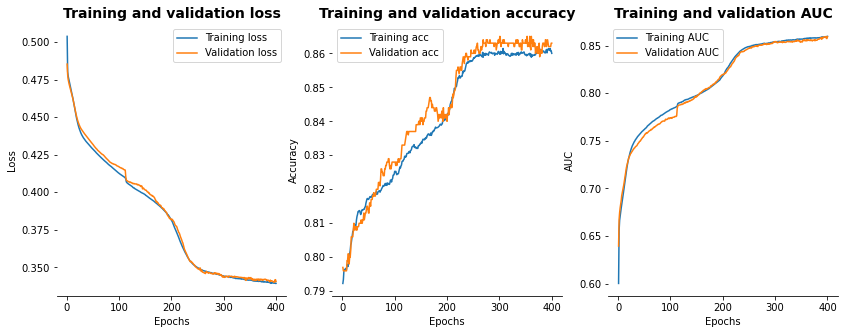

In [128]:
model.summary()
plot_history(history)

**The model did not overfit; however, the accuracy didn't increase after 250 epochs; I will use 250 epochs.**

## Let change the batch size.

In [129]:
batch_sizes = [16,32,64,256]
history_dict = {}
models_dict = {}
for i, batch_size in enumerate(batch_sizes):
  models_dict[i] = get_model()
  history_dict[i] = models_dict[i].fit(Xlearn,
                    ylearn,
                    epochs=250,
                    batch_size= batch_size,
                    verbose = 0,
                    shuffle = False,
                    validation_data=(Xval, yval))

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 12)                144       
                                                                 
 dense_132 (Dense)           (None, 6)                 78        
                                                                 
 dense_133 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


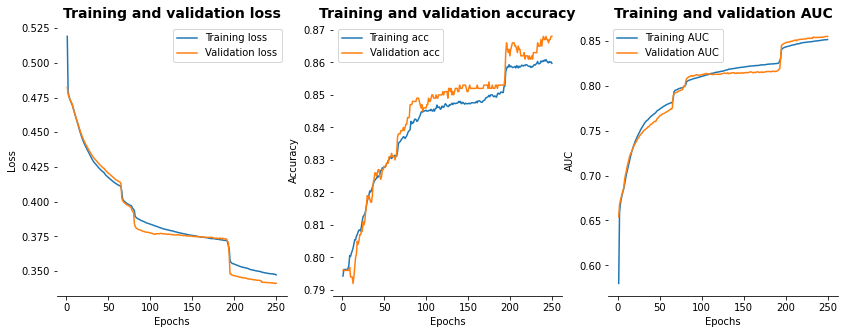

In [130]:
# batch_size= 16
models_dict[0].summary()
plot_history(history_dict[0])

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_134 (Dense)           (None, 12)                144       
                                                                 
 dense_135 (Dense)           (None, 6)                 78        
                                                                 
 dense_136 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


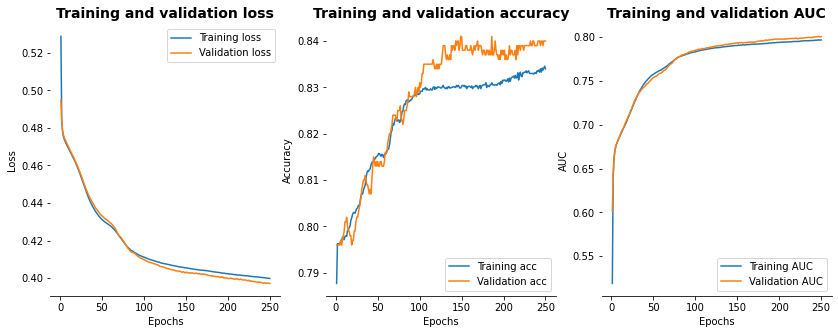

In [131]:
# batch_size= 32
models_dict[1].summary()
plot_history(history_dict[1])

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_137 (Dense)           (None, 12)                144       
                                                                 
 dense_138 (Dense)           (None, 6)                 78        
                                                                 
 dense_139 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


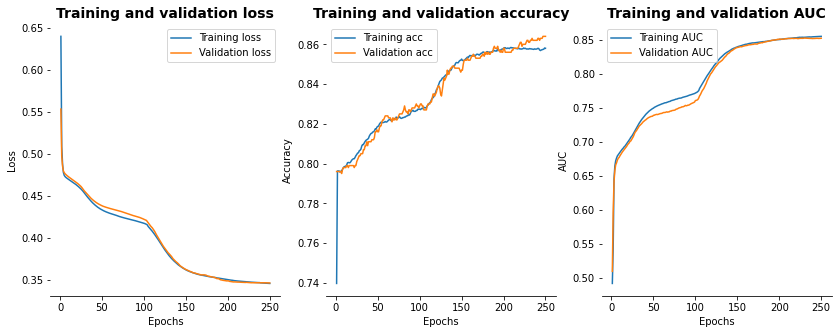

In [133]:
# batch_size= 64
models_dict[2].summary()
plot_history(history_dict[2])

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 12)                144       
                                                                 
 dense_141 (Dense)           (None, 6)                 78        
                                                                 
 dense_142 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


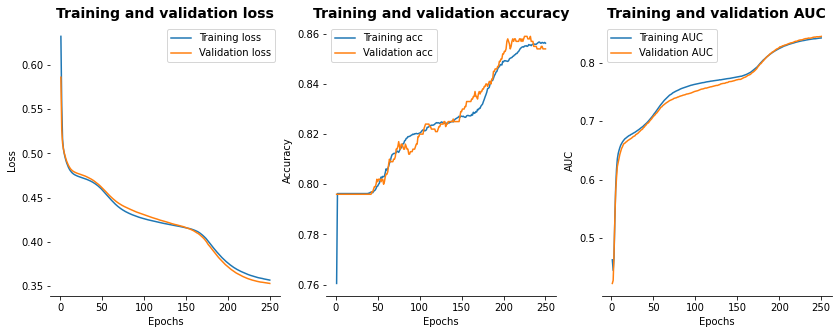

In [134]:
# batch_size= 256
models_dict[3].summary()
plot_history(history_dict[3])

**Batch size 16 appears to be the most appropriate.**

## Let's try with different activation function **tanh**

In [135]:
model_tanh = get_model(activation= "tanh")
history_tanh = model_tanh.fit(Xlearn,
                    ylearn,
                    epochs= 250,
                    batch_size= 16,
                    verbose = 0,
                    shuffle = False,
                    validation_data=(Xval, yval))

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 12)                144       
                                                                 
 dense_132 (Dense)           (None, 6)                 78        
                                                                 
 dense_133 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


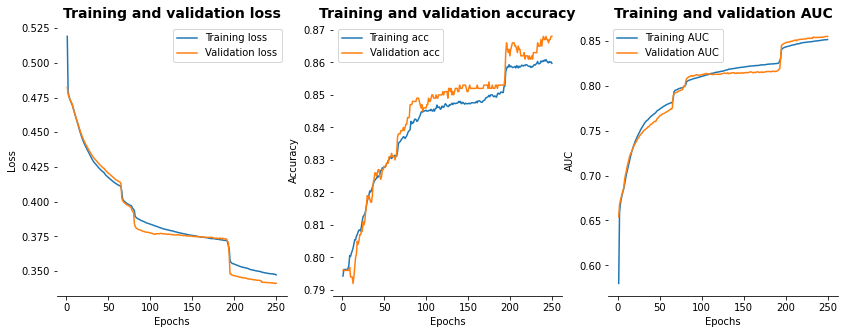

In [137]:
# relu activation
models_dict[0].summary()
plot_history(history_dict[0])

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_143 (Dense)           (None, 12)                144       
                                                                 
 dense_144 (Dense)           (None, 6)                 78        
                                                                 
 dense_145 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


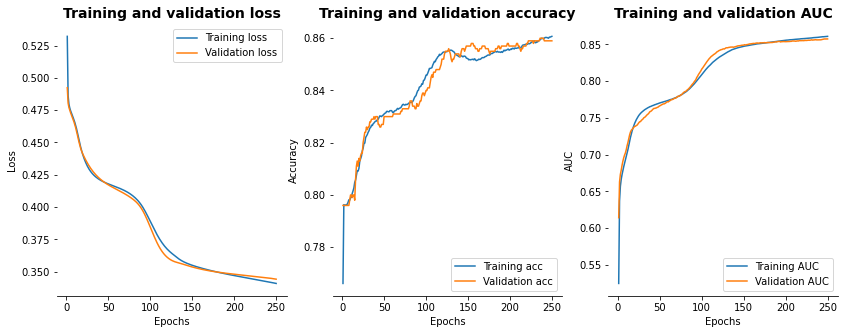

In [136]:
# tanh activation
model_tanh.summary()
plot_history(history_tanh)

Both produced fairly similar outcomes; I will stick with **relu**

## Let's try with different optimizer **rmsprop**

In [138]:
model_rmspro = get_model(optimizer= "rmsprop")
history_rmspro = model_rmspro.fit(Xlearn,
                    ylearn,
                    epochs=250,
                    batch_size= 16,
                    verbose = 0,
                    shuffle = False,
                    validation_data=(Xval, yval))

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 12)                144       
                                                                 
 dense_132 (Dense)           (None, 6)                 78        
                                                                 
 dense_133 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


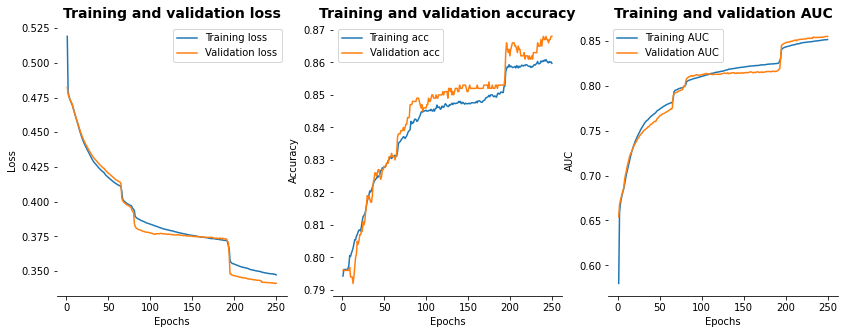

In [139]:
# adam optimizer
models_dict[0].summary()
plot_history(history_dict[0])

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_146 (Dense)           (None, 12)                144       
                                                                 
 dense_147 (Dense)           (None, 6)                 78        
                                                                 
 dense_148 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


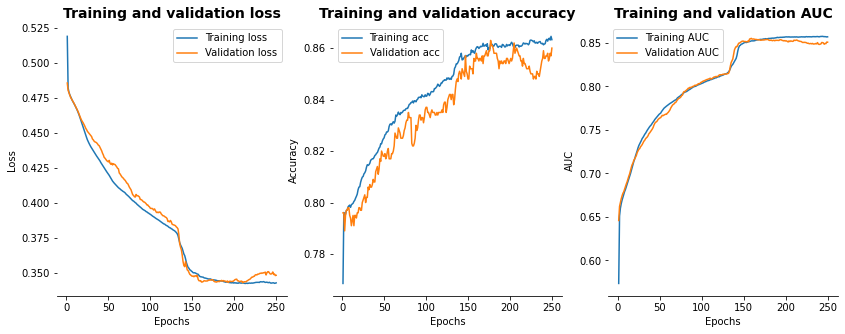

In [140]:
# rmsprop optimizer
model_rmspro.summary()
plot_history(history_rmspro)

**Adam** optimizer produced better outcomes; I will use it

## Let's put regularization **dropout** into action, and see the results.

In [141]:
def get_dropout_model(L1_output= 12,L2_output=6, activation="relu",optimizer="adam"):

  model = keras.Sequential([
  layers.Dense(L1_output, activation=activation),
  layers.Dropout(0.5),
  layers.Dense(L2_output, activation=activation),
  layers.Dense(1, activation= "sigmoid")
  ])

  model.compile(optimizer= optimizer,
  loss="binary_crossentropy",
  metrics=["accuracy","AUC"])

  return model

In [142]:
model_dropout = get_dropout_model()
history_dropout = model_dropout.fit(Xlearn,
                  ylearn,
                  epochs=250,
                  batch_size= 16,
                  verbose = 0,
                  shuffle = False,
                  validation_data=(Xval, yval))

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 12)                144       
                                                                 
 dense_132 (Dense)           (None, 6)                 78        
                                                                 
 dense_133 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


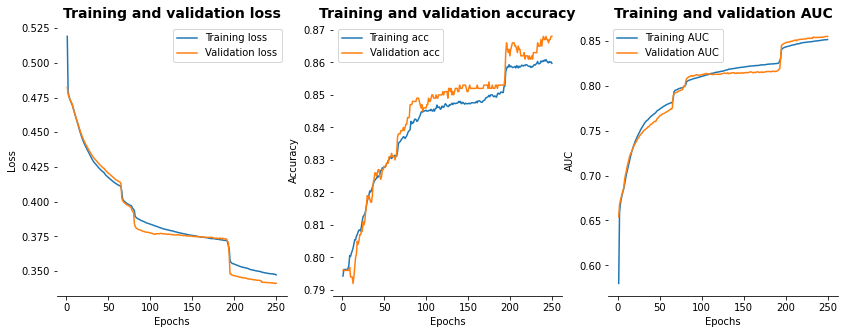

In [144]:
# without dropout
models_dict[0].summary()
plot_history(history_dict[0])

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_149 (Dense)           (None, 12)                144       
                                                                 
 dropout_4 (Dropout)         (None, 12)                0         
                                                                 
 dense_150 (Dense)           (None, 6)                 78        
                                                                 
 dense_151 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


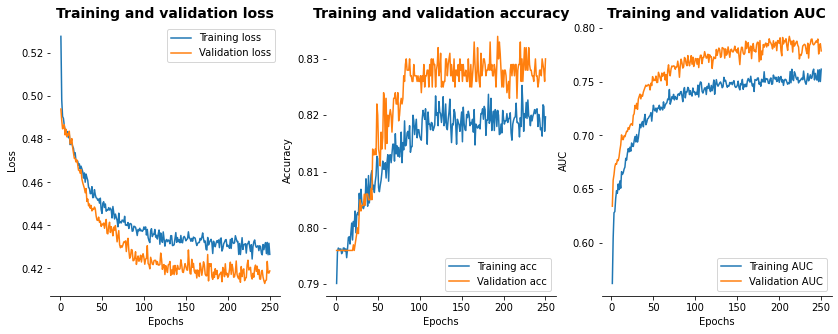

In [143]:
model_dropout.summary()
plot_history(history_dropout)

**The results without dropout layer were better, but I will add additional hidden layers and test with dropout.**

## Let's add additional hidden layers, and see the results.

In [145]:
def get_dropout_4lay_model(L1_output= 12,L2_output=6, activation="relu",optimizer="adam"):

  model = keras.Sequential([
  layers.Dense(L1_output, activation=activation),
  layers.Dense(L1_output, activation=activation),
  layers.Dropout(0.5),
  layers.Dense(L2_output, activation=activation),
  layers.Dense(L2_output, activation=activation),
  layers.Dense(1, activation= "sigmoid")
  ])

  model.compile(optimizer= optimizer,
  loss="binary_crossentropy",
  metrics=["accuracy","AUC"])

  return model

In [146]:
dropout_4lay_model = get_dropout_4lay_model()
dropout_4lay_history = dropout_4lay_model.fit(Xlearn,
                  ylearn,
                  epochs=250,
                  batch_size= 16,
                  verbose = 0,
                  shuffle = False,
                  validation_data=(Xval, yval))

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_152 (Dense)           (None, 12)                144       
                                                                 
 dense_153 (Dense)           (None, 12)                156       
                                                                 
 dropout_5 (Dropout)         (None, 12)                0         
                                                                 
 dense_154 (Dense)           (None, 6)                 78        
                                                                 
 dense_155 (Dense)           (None, 6)                 42        
                                                                 
 dense_156 (Dense)           (None, 1)                 7         
                                                                 
Total params: 427
Trainable params: 427
Non-trainable

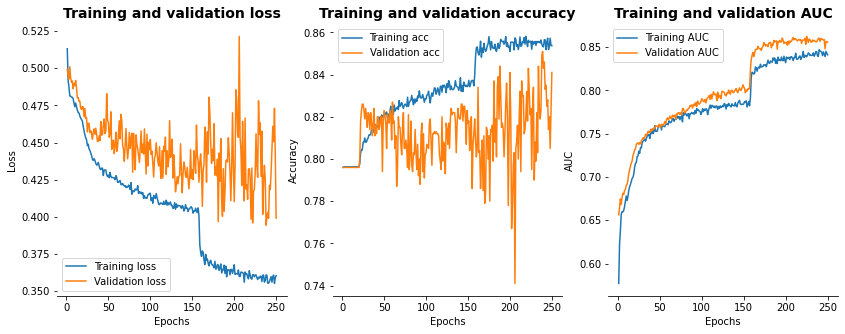

In [147]:
dropout_4lay_model.summary()
plot_history(dropout_4lay_history)

**Validation loss and accuracy with the simpler model were better, therefore I will stick with the simpler model.**

## Let's change the class weights, and see the results.

In [148]:
class_weight_model = get_model()
class_weight_history = class_weight_model.fit(Xlearn,
                  ylearn,
                  epochs= 250,
                  batch_size= 16,
                  verbose = 0,
                  shuffle = False,
                  class_weight = {1: np.mean((ylearn) == 0),
                                  0: np.mean((ylearn) == 1)},
                  validation_data=(Xval, yval))

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_157 (Dense)           (None, 12)                144       
                                                                 
 dense_158 (Dense)           (None, 6)                 78        
                                                                 
 dense_159 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


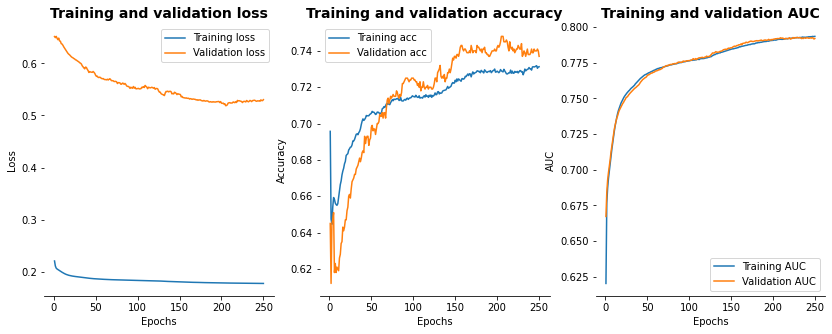

In [149]:
class_weight_model.summary()
plot_history(class_weight_history)

**It does not appear to be enhancing the results.**

## Stop training when a validation loss has stopped improving.

In [150]:
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                               patience = 10,
                                               restore_best_weights = True)

In [152]:
early_stopping_model = get_model()
early_stopping_history = early_stopping_model.fit(Xlearn,
                  ylearn,
                  epochs= 250,
                  batch_size= 16,
                  verbose = 0,
                  shuffle = False,
                  callbacks = early_stopping,
                  validation_data=(Xval, yval))

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_163 (Dense)           (None, 12)                144       
                                                                 
 dense_164 (Dense)           (None, 6)                 78        
                                                                 
 dense_165 (Dense)           (None, 1)                 7         
                                                                 
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________


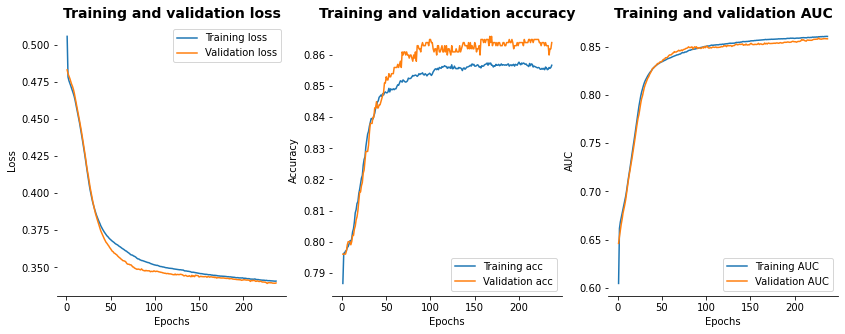

In [153]:
early_stopping_model.summary()
plot_history(early_stopping_history)

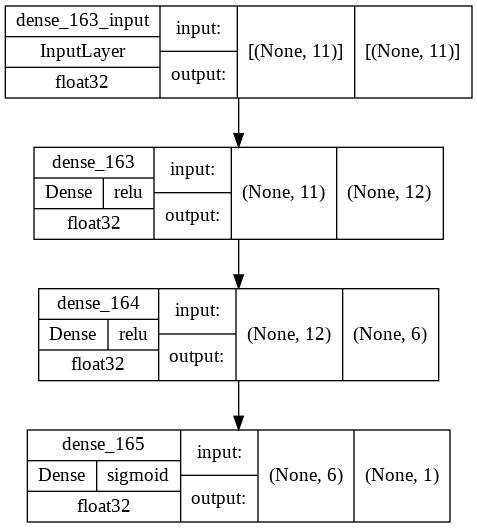

In [154]:
keras.utils.plot_model(early_stopping_model,
                       show_shapes = True,
                       show_dtype = True,
                       show_layer_activations = True)

In [155]:
print(early_stopping_model.evaluate(Xlearn, ylearn))

219/219 [==============================] - 1s 4ms/step - loss: 0.3374 - accuracy: 0.8589 - auc: 0.8627
[0.3374480605125427, 0.8588571548461914, 0.8627123236656189]


In [156]:
print(early_stopping_model.evaluate(Xval, yval))


32/32 [==============================] - 0s 4ms/step - loss: 0.3391 - accuracy: 0.8640 - auc: 0.8592
[0.33914604783058167, 0.8640000224113464, 0.8592287302017212]


In [157]:
print(early_stopping_model.evaluate(Xtest, ytest))

63/63 [==============================] - 0s 3ms/step - loss: 0.3627 - accuracy: 0.8550 - auc: 0.8365
[0.36270081996917725, 0.8550000190734863, 0.8364728093147278]


**The accuracy on the test data is 85.5%, and the AUC is 0.83.**